# Coding project - Watermark
By Alexandre Achten - 000494484
2023
## Get information about the images

Image dimensions:  (900, 1200, 3) Image type:  uint8
Watermark dimensions:  (85, 219, 3) Watermark type:  uint8


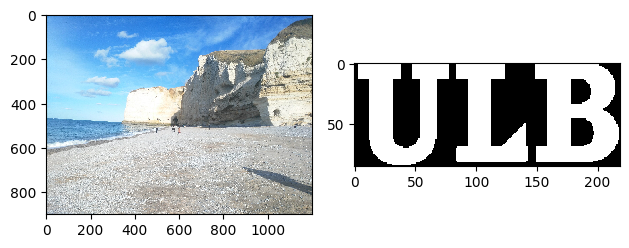

In [2]:
import numpy as np
from skimage.io import imread, imsave, imshow
import matplotlib.pyplot as plt
%matplotlib inline
WHITE = 255
BLACK = 0

# read image and watermark
img = imread("etretat.jpg")
wm = imread("watermark.png")

#show dimensions and type of image and watermark
print("Image dimensions: ", img.shape, "Image type: ", img.dtype)
print("Watermark dimensions: ", wm.shape, "Watermark type: ", wm.dtype)
#show images
plt.subplot(1,2,1)
imshow(img)
plt.subplot(1,2,2)
imshow(wm)
plt.show()


## Transform the images
Here we will keep only the white pixels of the watermark and transform the image in a grayscale image. Then we will add it to the image we want to watermark.

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


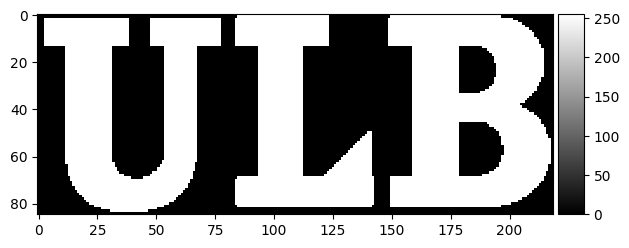

In [3]:
# Keep white pixels of watermark and transform in greyscale image
def get_logo(im):
    im2 = np.zeros((im.shape[0], im.shape[1]))
    # get white pixels
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if im[y,x,0] == 255 and im[y,x,1] == 255 and im[y,x,2] == 255:
                im2[y,x] = 255
    return im2
    
logo = get_logo(wm)
imshow(logo,cmap='gray')

We will add an alpha channel to enable the transparency of the watermark and the image. (cf. RGBA)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image dimensions:  (900, 1200, 4) Image type:  uint8


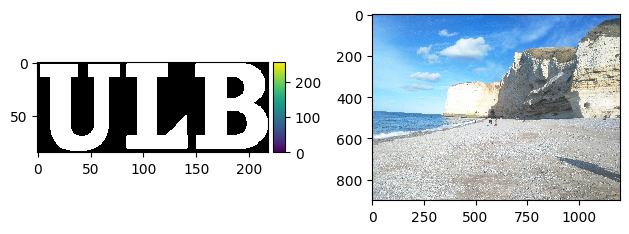

In [4]:
def add_alpha_channel(im):
    im2 = np.zeros((im.shape[0], im.shape[1], 4),dtype=im.dtype) #create image with 4 channels
    if len(im.shape) == 2: #case greyscale image
        for y in range(im.shape[0]):
            for x in range(im.shape[1]):
                im2[y,x,0] = im[y,x]
                im2[y,x,1] = im[y,x]
                im2[y,x,2] = im[y,x]
                im2[y,x,3] = 255
    elif im.shape[2] == 4: #case already alpha channel
        return im
    else : #case RGB image
        for y in range(im.shape[0]):
            for x in range(im.shape[1]):
                im2[y,x,0] = im[y,x,0]
                im2[y,x,1] = im[y,x,1]
                im2[y,x,2] = im[y,x,2]
                im2[y,x,3] = 255
    return im2
alpha_logo = add_alpha_channel(logo)
alpha_img = add_alpha_channel(img)
print("Image dimensions: ", alpha_img.shape, "Image type: ", alpha_img.dtype)
plt.subplot(1,2,1)
imshow(alpha_logo)
plt.subplot(1,2,2)
imshow(alpha_img)
plt.show()

We will create a mask for the watermark to be able to add it to the image.


C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


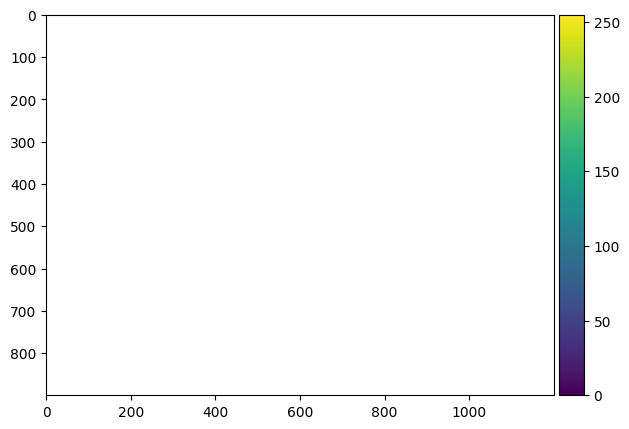

In [5]:
def get_mask_wm(wm,im,pos=(0,0)):
    mask = np.zeros((im.shape[0], im.shape[1],im.shape[2]),dtype=im.dtype)
    mask[:,:,3] = 0 #make the alpha channel transparent
    for y in range(wm.shape[0]):
        for x in range(wm.shape[1]):
            if (wm[y,x,0] == 255 and wm[y,x,1] == 255 and wm[y,x,2] == 255):
                mask[pos[0]+y,pos[1]+x] = wm[y,x]
    return mask
wm_mask = get_mask_wm(alpha_logo,alpha_img,[500,500])
imshow(wm_mask)

## Add the watermark
Now we can add the watermark to the image specifying the position of the watermark and th transparency level (between 0 and 255).

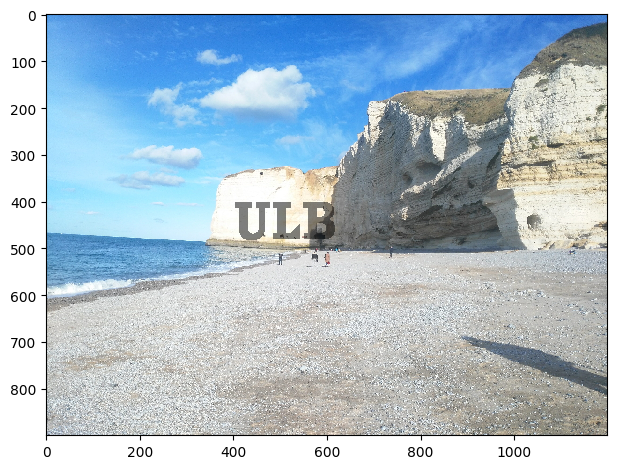

In [6]:

#add watermark when two images have RGBA channels
def add_wm_alpha(im,wm,transparency=0.3):
    im2=im.copy()
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            pixel_overlay = wm[y,x] #pixel to superpose
            base_pixel = im[y,x] #pixel of the base image
            alpha_pixel = transparency
            base_ratio = 1-transparency
            rgb = pixel_overlay[:3]*alpha_pixel + base_pixel[:3]*base_ratio #weighted average of color of two pixels
            alpha= transparency*255
            im2[y,x] = np.concatenate((rgb,[alpha])) #concatenate color and alpha channel
    return im2

def check_luminosity(im,wm,pos):
    colors = [0,0,0]
    for y in range(wm.shape[0]):
        for x in range(wm.shape[1]):
            colors += im[pos[0]+y,pos[1]+x]
    mean_color = colors/(wm.shape[0]*wm.shape[1])
    if mean_color[0] > 200 and mean_color[1] > 200 and mean_color[2] > 200:
        return True
    else:
        return False
    
def add_wm(im,wm,pos,transparency=0.5):
    im2=im.copy()
    luminosity = check_luminosity(im,wm,pos)
    for y in range(wm.shape[0]):
        for x in range(wm.shape[1]):
            if (wm[y,x]==WHITE).all():
                if luminosity:
                    wm[y,x]=BLACK
                im2[pos[0]+y,pos[1]+x]=im2[pos[0]+y,pos[1]+x]*(1-transparency)+wm[y,x]*transparency #mix two pixels
    return im2
#final_img = add_wm_alpha(alpha_img,wm_mask)
# imshow(final_img)
logo = get_logo(wm)
position = [400,400]
final_img=add_wm(img,logo,position)
imshow(final_img)